# 3b. Fitting carbonate and SO$_2$ peaks
- This notebook shows how to fit secondary peaks, such as carbonate and S-rich phases in vapour bubbles and fluid inclusions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from tqdm import tqdm
pf.__version__

'1.0.5'

In [2]:
# Here, we are loading in the settings files from Step1. If all you want to do is find secondary phases, paste that code here
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

In [3]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'diad', 'CRR', 'secphase','Series','unquant','Series','map','ol','away','broad','notFI']
Diad_Files=pf.get_files(path=spectra_path, file_ext=spectra_file_ext, exclude_str=exclude_str)
print(Diad_Files)
File_df=pd.DataFrame(data={'filename': Diad_Files})

['05 K21-65-FI#1-12mW.txt', '06 K21-65-FI#1-10mW.txt', '08 K21-65-FI#1-8mW.txt', '09 K21-65-FI#1-6mW.txt', '10 K21-65-FI#1-4mW.txt', '12 K21-65-FI#1-2mW.txt', '13 K21-65-FI#1-2mWup.txt', '14 K21-65-FI#1-4mWup.txt', '15 K21-65-FI#1-6mWup.txt', '16 K21-65-FI#1-8mWup.txt', '18 K21-65-FI#1-10mWup.txt', '19 K21-65-FI#1-12mWup.txt', '23 K21-66-FI#3-bump.txt', '24 K21-66-FI#4.txt', '27 K21-68-FI#1.txt', '28 K21-68-FI#2.txt', '32 K21-69-FI#1.txt', '34 K21-69-FI#2.txt', '35 K21-69-FI#3.txt', '37 K21-69-FI#5.txt', '39 K21-69-FI#6.txt', '41 K21-70-FI#1.txt']


## Plot spectra in a given region of space to examine secondary peaks or not

### You'll need to tweak the peak parameters to find them
- height = minimum height a peak should have to be identified
- threshold = required vertical distance between a peak and its neighbours
- distance = required horizontal distance bewteen neighbouring peaks. 
- prominence = required prominence of peaks
- width = width of peaks


## Example 1 - Using Scipy find peaks to look for SO2

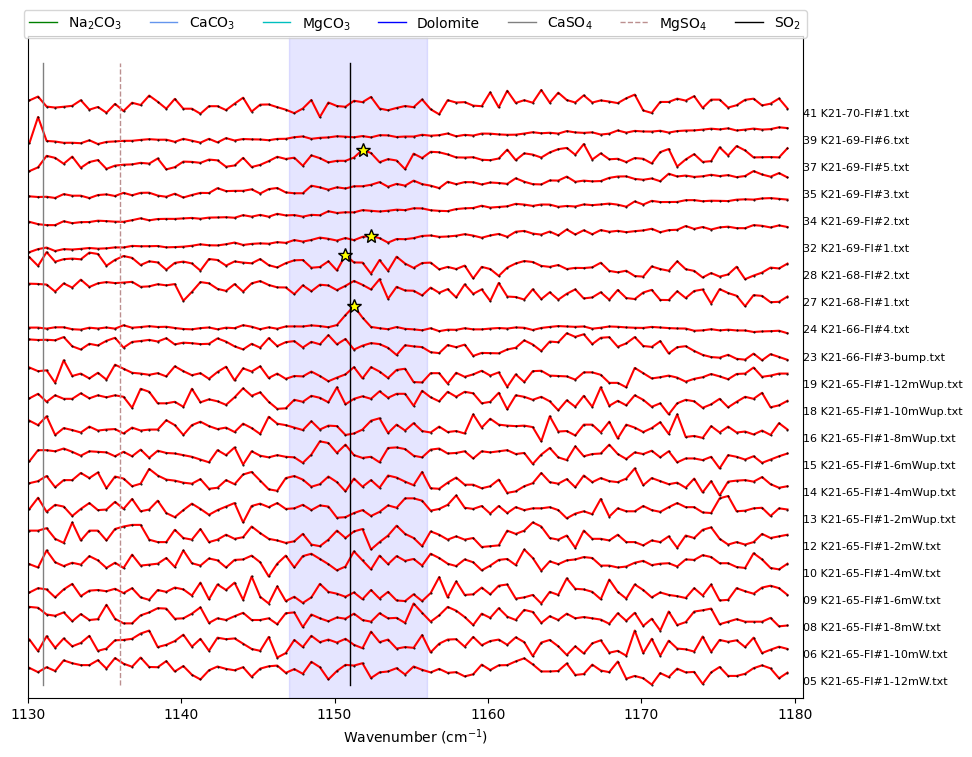

In [33]:
prominence_SO2=20
height_SO2=5
width_SO2=2
threshold_SO2=0

SO2_peaks_scipy, x_data_scipy, y_data_scipy, fig_scipy=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
filetype=spectra_filetype, find_peaks_filter=True,  
xlim_peaks=[1147, 1156], xlim_plot=[1130, 1180], yscale=0.3,
prominence=prominence_SO2, height=height_SO2, width=width_SO2, threshold=threshold_SO2)

SO2_peaks=SO2_peaks_scipy

In [34]:
SO2_peaks

,pos,height,prom,file_names
0,NaN,NaN,NaN,05 K21-65-FI#1-12mW.txt
1,NaN,NaN,NaN,06 K21-65-FI#1-10mW.txt
2,NaN,NaN,NaN,08 K21-65-FI#1-8mW.txt
3,NaN,NaN,NaN,09 K21-65-FI#1-6mW.txt
4,NaN,NaN,NaN,10 K21-65-FI#1-4mW.txt
5,NaN,NaN,NaN,12 K21-65-FI#1-2mW.txt
6,NaN,NaN,NaN,13 K21-65-FI#1-2mWup.txt
7,NaN,NaN,NaN,14 K21-65-FI#1-4mWup.txt
8,NaN,NaN,NaN,15 K21-65-FI#1-6mWup.txt
9,NaN,NaN,NaN,16 K21-65-FI#1-8mWup.txt


### Now filter out ones with no peaks, or low prominence before we loop through them

In [46]:
# Remove the ones where it didnt find SO2
SO2_notNa=np.isnan(SO2_peaks['pos'])
# Remove ones with a prominence less than this. 
prom_filt=40
SO2_filter=((SO2_peaks['prom']>prom_filt))&(~SO2_notNa)&(~SO2_peaks['file_names'].str.contains("30|31"))
print('Number kept with this filter:')
print(sum(SO2_filter))
print('Number discarded:')
print(sum(~SO2_filter&(~SO2_notNa)))
filenames_SO2=list(File_df['filename'].loc[SO2_filter])
print('filenames with SO2:')
print(filenames_SO2)

Number kept with this filter:
1
Number discarded:
3
filenames with SO2:
['24 K21-66-FI#4.txt']


### Choose a filename to test peak fits

In [47]:
if sum(SO2_filter)>0:
    filename=filenames_SO2[0]

### Set up configuration file for S peak fitting
- Here, we are using a spline to quantify the area down to the 92% of the peak height (int_cut_of=0.08), there are differen options you can use for this

generic_peak_config(name='SO2', lower_bck=[1125, 1140], upper_bck=[1165, 1190], model_name='Spline', x_range_bck=20, N_poly_carb_bck=1, amplitude=1000, cent=1150, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=[1160, 1180], return_other_params=False, N_peaks=1, int_cut_off=0.05)


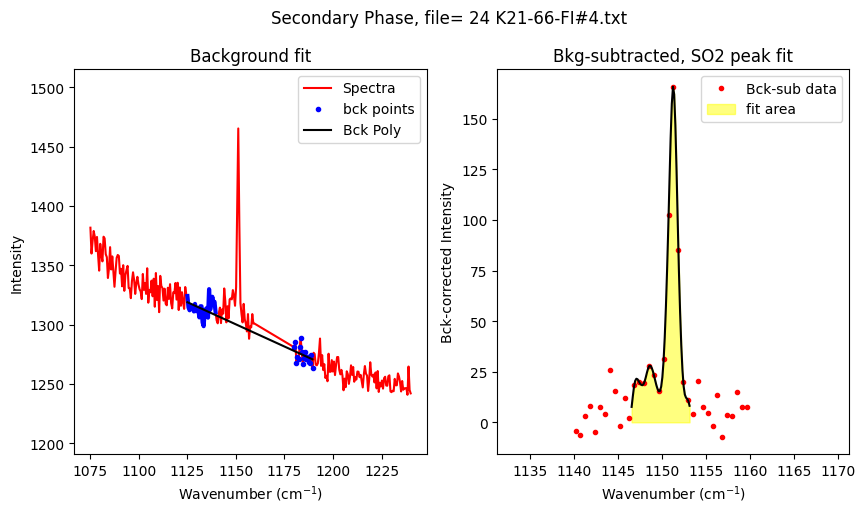

In [48]:
if sum(SO2_filter)>0:
    SO2_peak_config=pf.generic_peak_config(name='SO2', lower_bck=[1125, 1140],
    upper_bck=[1165, 1190], exclude_range=[1160,1180],cent=1150, x_range_bck=20, N_peaks=1,   model_name='Spline', int_cut_off=0.05)
    print(SO2_peak_config)

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
    path=spectra_path, filename=filename, filetype=spectra_filetype, 
     plot_figure=True)

## Now lets loop through files

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


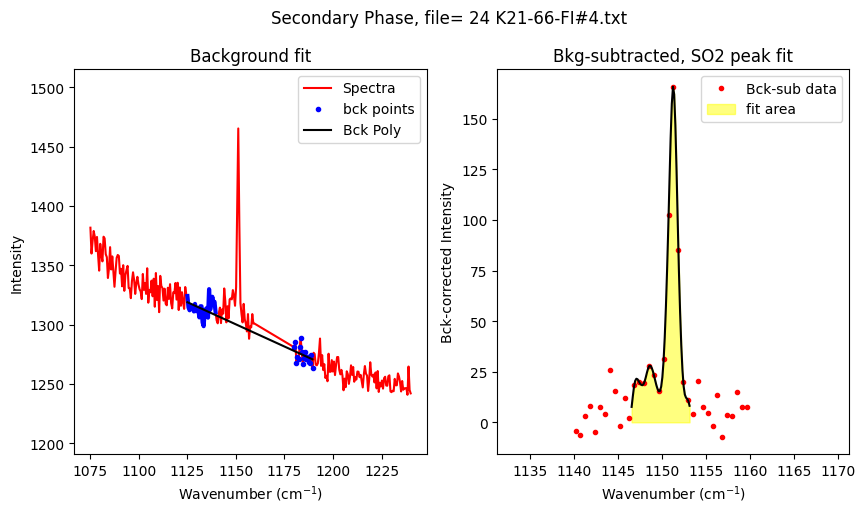

In [49]:
files_to_fit=filenames_SO2
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_SO2 = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    SO2_peak_fit=pf.fit_generic_peak(config=SO2_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_SO2 = pd.concat([df_Merge_SO2, SO2_peak_fit], axis=0)

In [50]:
df_Merge_SO2

,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name
0,24 K21-66-FI#4.txt,1151.240348,298.373152,165.971331,Spline


### Plot peak areas and peak heights

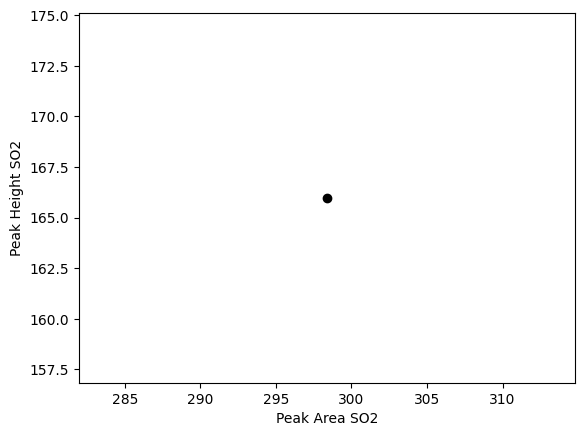

In [51]:
if sum(SO2_filter)>0:
    plt.plot(df_Merge_SO2['Peak_Area_SO2'], 
            df_Merge_SO2['Peak_Height_SO2'], 'ok')
    plt.xlabel('Peak Area SO2')
    plt.ylabel('Peak Height SO2')
    # plt.yscale('log')
# plt.xscale('log')

### Save this to excel

In [52]:
if sum(SO2_filter)>0:
    df_Merge_SO2['filename'] = df_Merge_SO2['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_SO2.to_excel('SO2_Peak_fits.xlsx', index=False)

## Now do the same to ID any carbonate peaks

### Using scipy find peaks methods
- This method doesnt always work perfectly for broader carbonate peaks

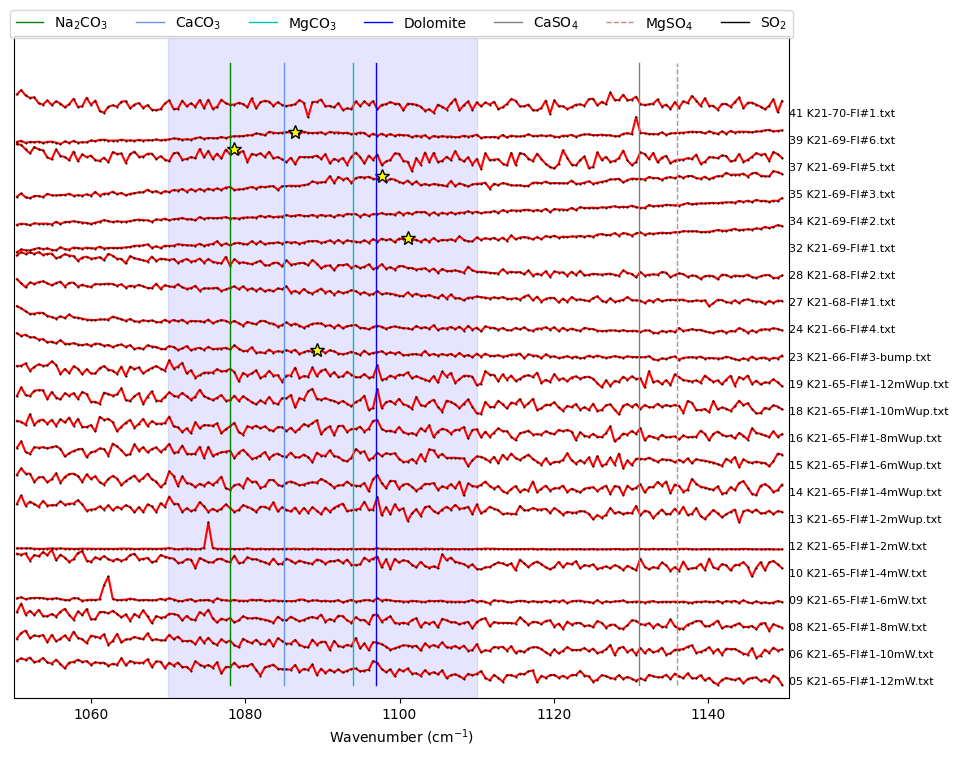

In [53]:

prominence_carb=10
height_carb=10
width_carb=4
threshold_carb=1

Carb_peaks_scipy, x_data_scipy, y_data_scipy, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, find_peaks_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1070, 1110], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)
Carb_peaks=Carb_peaks_scipy

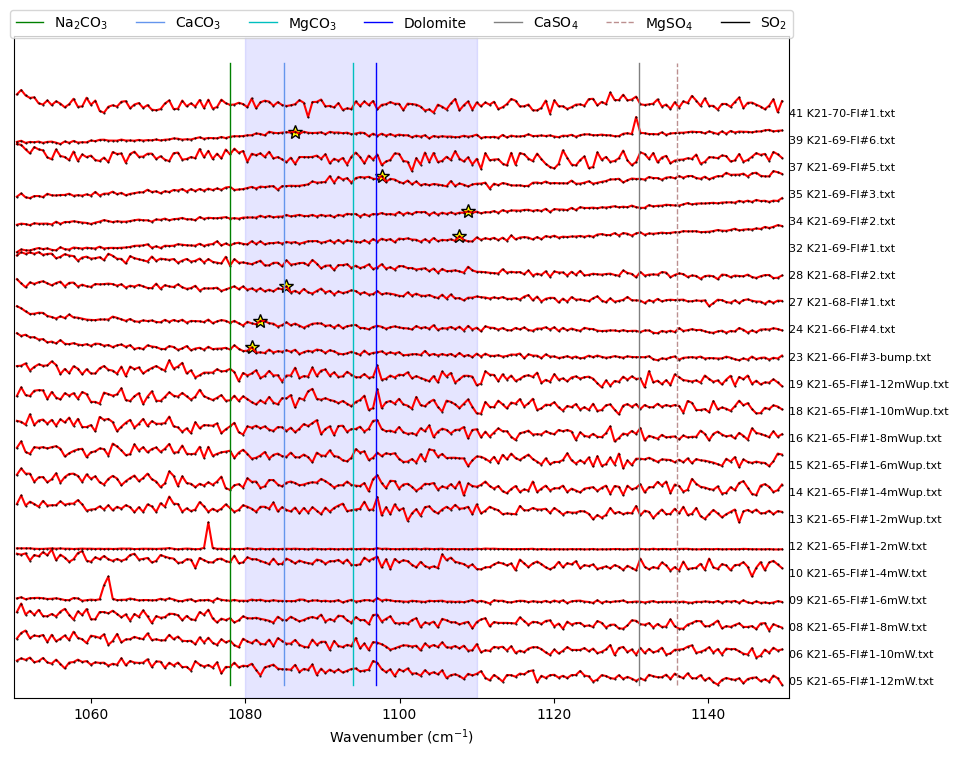

In [54]:

prominence_carb=30
height_carb=10
width_carb=4
threshold_carb=1

Carb_peaks_prom, x_data_prom, y_data_prom, fig=pf.plot_secondary_peaks(
Diad_Files=Diad_Files, path=spectra_path, 
 filetype=spectra_filetype, prominence_filter=True,  
xlim_plot=[1050, 1150], xlim_peaks=[1080, 1110], yscale=0.3,
prominence=prominence_carb, height=height_carb, width=width_carb, threshold=threshold_carb)

# Carb_peaks=Carb_peaks_prom

In [55]:
Carb_peaks

,pos,height,prom,file_names
0,NaN,NaN,NaN,05 K21-65-FI#1-12mW.txt
1,NaN,NaN,NaN,06 K21-65-FI#1-10mW.txt
2,NaN,NaN,NaN,08 K21-65-FI#1-8mW.txt
3,NaN,NaN,NaN,09 K21-65-FI#1-6mW.txt
4,NaN,NaN,NaN,10 K21-65-FI#1-4mW.txt
5,NaN,NaN,NaN,12 K21-65-FI#1-2mW.txt
6,NaN,NaN,NaN,13 K21-65-FI#1-2mWup.txt
7,NaN,NaN,NaN,14 K21-65-FI#1-4mWup.txt
8,NaN,NaN,NaN,15 K21-65-FI#1-6mWup.txt
9,NaN,NaN,NaN,16 K21-65-FI#1-8mWup.txt


## Find ones with certain peak parameters to include

In [70]:
Carb_noNa=np.isnan(Carb_peaks['pos'])
prom_filter=5
Carb_filter=((Carb_peaks['prom']>prom_filter))&(~Carb_noNa)&(Carb_peaks['pos'].between(1085,1087))
print('Number kept with this filter:')
print(sum(Carb_filter))
print('Number discarded:')
print(sum(~Carb_filter&(~Carb_noNa)))
filenames_Carb=list(File_df['filename'].loc[Carb_filter])
print('filenames with carb:')
print(filenames_Carb)

Number kept with this filter:
1
Number discarded:
4
filenames with carb:
['39 K21-69-FI#6.txt']


### Fit one to tweak parameters

generic_peak_config(name='Carb', lower_bck=[1050, 1065], upper_bck=[1119, 1150], model_name='Spline', x_range_bck=50, N_poly_carb_bck=2, amplitude=1000, cent=1090, outlier_sigma=12, distance=10, prominence=5, width=6, threshold=0.1, height=100, exclude_range=None, return_other_params=False, N_peaks=1, int_cut_off=0.05)


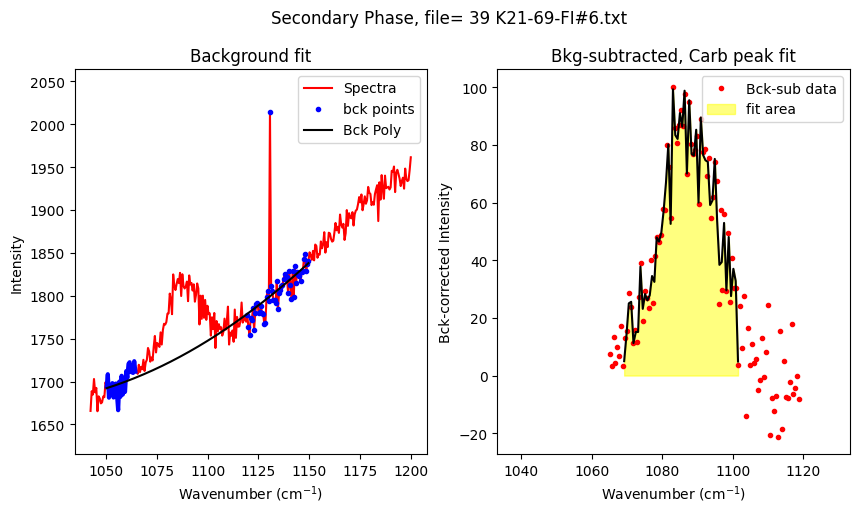

In [71]:
if sum(Carb_filter)>0:
    filename_carb=filenames_Carb[0]

    Carb_peak_config=pf.generic_peak_config(name='Carb', lower_bck=[1050, 1065],
    upper_bck=[1119, 1150], cent=1090, x_range_bck=50, N_poly_carb_bck=2, model_name='Spline')
    print(Carb_peak_config)

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
    path=spectra_path, filename=filename_carb, filetype=spectra_filetype,
     plot_figure=True)

### Loop over all carbonate files

100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


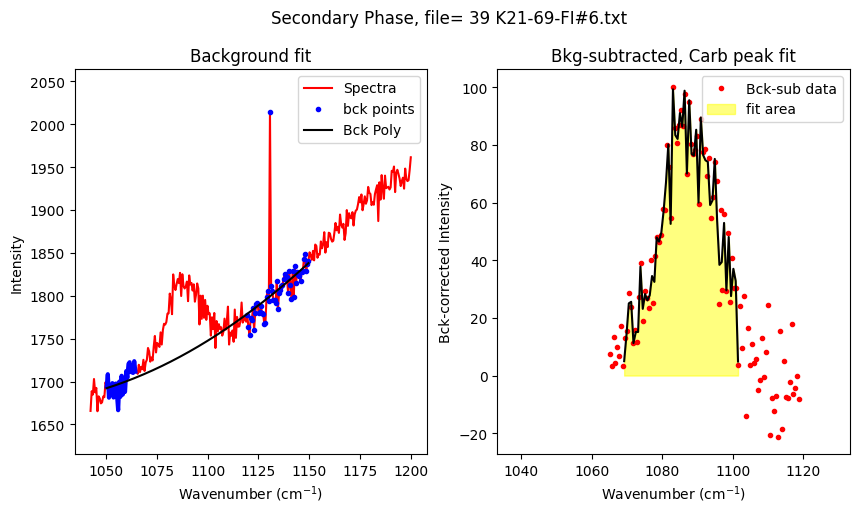

In [72]:
files_to_fit=filenames_Carb
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself

df_Merge_Carb = pd.DataFrame([])

for i in tqdm(range(0, len(files_to_fit))): #
    
    ## Diad 1 fit
    filename=files_to_fit[i]

    Carb_peak_fit=pf.fit_generic_peak(config=Carb_peak_config, 
path=spectra_path, filename=filename, filetype=spectra_filetype,
 plot_figure=plot_figure)
 
    df_Merge_Carb = pd.concat([df_Merge_Carb, Carb_peak_fit], axis=0)

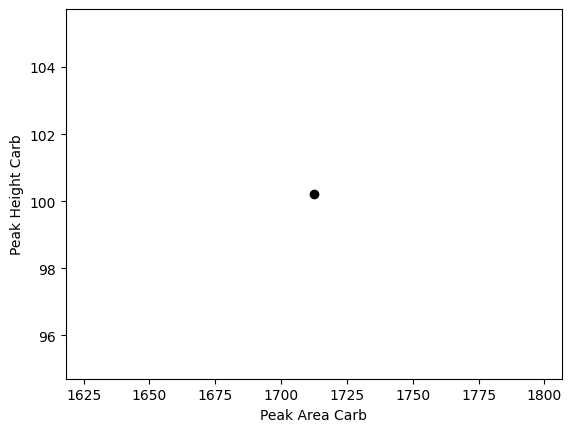

In [73]:
if sum(Carb_filter)>0:
    plt.plot(df_Merge_Carb['Peak_Area_Carb'], 
        df_Merge_Carb['Peak_Height_Carb'], 'ok')
    plt.xlabel('Peak Area Carb')
    plt.ylabel('Peak Height Carb')
# plt.yscale('log')
# plt.xscale('log')

## Save to excel

In [74]:
if sum(Carb_filter)>0:
    df_Merge_Carb['filename'] = df_Merge_Carb['filename'].str.replace('--Spec.Data 1', '')
    df_Merge_Carb.to_excel('Carb_Peak_fits.xlsx', index=False )

In [75]:
df_Merge_Carb

,filename,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb,Model_name
0,39 K21-69-FI#6.txt,1083.191733,1712.374318,100.216977,Spline


In [76]:
import os

if os.name=="posix":

    def mac_notification(title, subtitle, message):
        """
        Display a macOS notification with the default sound using AppleScript.
        
        Args:
        - title: Title of the notification.
        - subtitle: Subtitle of the notification.
        - message: Main message content of the notification.
        """
        os.system("""
                osascript -e 'display notification "{}" with title "{}" subtitle "{}" sound name "default"'
                """.format(message, title, subtitle))

    mac_notification("Notebook Completed", "VSCode", "Step3b Secondary peaks")

else:

    # %pip install winotify

    from winotify import Notification, audio

    toast= Notification(app_id="VSCode",title="Notebook completed",
                        msg="Step3b_Secondary_Peaks is done!",
                        duration="short")
    toast.set_audio(audio.Mail,loop=False)
    toast.show()